In [1]:
from vlm_tools import load_model_and_processor, dissect_image
from PIL import Image
import torch

model, processor = load_model_and_processor()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## What Does Gemma 3 Actually "See"?

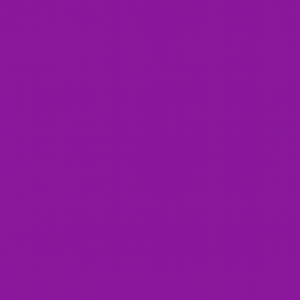

┌───────────────┬───────────┬────────────┐
│ decoded_token │ frequency │ percentage │
│    varchar    │   int64   │   double   │
├───────────────┼───────────┼────────────┤
│ " the"        │       169 │       66.0 │
│ "Purple"      │        33 │       12.9 │
│ " a"          │        14 │        5.5 │
│ " "           │        11 │        4.3 │
│ "the"         │        11 │        4.3 │
│ "0"           │         9 │        3.5 │
│ "formerly"    │         4 │        1.6 │
│ "1"           │         2 │        0.8 │
│ " purple"     │         1 │        0.4 │
│ " Wallpaper"  │         1 │        0.4 │
│ "mathrm"      │         1 │        0.4 │
├───────────────┴───────────┴────────────┤
│ 11 rows                      3 columns │
└────────────────────────────────────────┘



In [2]:
display(Image.open("images/monocolor.png").resize((300, 300)))
dissect_image("images/monocolor.png", model, processor)

## The Architecture: Translating Images Into Language Space

In [3]:
model

Gemma3ForConditionalGeneration(
  (model): Gemma3Model(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(4096, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwi

<img src="diagrams/VisionTransformerDataFlow.svg" width="1000">
<!-- ![VisionTransformerDataFlow.svg](diagrams/VisionTransformerDataFlow.svg) -->

<img src="diagrams/VisionLanguageModelDataFlow.svg" width="1000">
<!-- ![VisionLanguageModelDataFlow.svg](diagrams/VisionLanguageModelDataFlow.svg) -->

## Unembedding: Finding the Nearest Vocabulary Token to Any Embedding Vector

### Validation: Text Tokens Unembed Perfectly

In [4]:
hello_input = processor.tokenizer.encode(
    "Hello", add_special_tokens=False, return_tensors="pt"
).to("mps")
hello_embedding = model.get_input_embeddings()(hello_input)
unembedding_logits = model.lm_head(hello_embedding)

token_probabilities = torch.softmax(unembedding_logits, dim=-1)
top_probs, top_token_ids = torch.topk(token_probabilities.squeeze(), 10)

for prob, token_id in zip(top_probs, top_token_ids):
    decoded_token = processor.tokenizer.decode(token_id.item())
    print(f"{f'"{decoded_token}"':>9}: {prob.item():.12f}")

  "Hello": 1.000000000000
 " Hello": 0.000431060791
  "hello": 0.000001370907
 " hello": 0.000000305474
  "HELLO": 0.000000001251
  "Hallo": 0.000000000016
   "Hola": 0.000000000008
     "Hi": 0.000000000007
    "Hey": 0.000000000001
"Bonjour": 0.000000000000


In [5]:
dissect_image??

Signature:
dissect_image(
    image_path: str,
    model: transformers.models.gemma3.modeling_gemma3.Gemma3ForConditionalGeneration,
    processor: transformers.models.auto.processing_auto.AutoProcessor,
) -> None
Source:   
def dissect_image(
    image_path: str, model: Gemma3ForConditionalGeneration, processor: AutoProcessor
) -> None:
    """
    Given an image, run the image through Gemma 3's vision tower and multi modal projector.
    Given those 256 image tokens, unembed them.
    Then, run frequency counts across the tokens that occur from the unembed.
    """
    image_tokens = extract_image_tokens(image_path, model, processor)
    vocabulary_tokens = unembed_to_vocabulary(image_tokens, model, processor)
    analyze_token_frequencies(vocabulary_tokens).show(max_rows=256)
File:      ~/Repos/dissecting-vlm/vlm_tools.py
Type:      function

## Examples: What AI Really "Sees" (A Lossy View, By Unembedding)

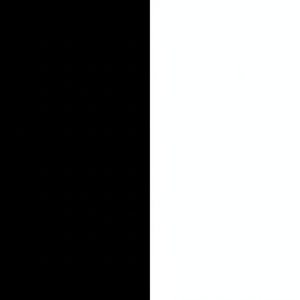

┌───────────────┬───────────┬────────────┐
│ decoded_token │ frequency │ percentage │
│    varchar    │   int64   │   double   │
├───────────────┼───────────┼────────────┤
│ " the"        │       191 │       74.6 │
│ " "           │        14 │        5.5 │
│ "0"           │        12 │        4.7 │
│ " black"      │         9 │        3.5 │
│ " white"      │         8 │        3.1 │
│ " bicolor"    │         7 │        2.7 │
│ "the"         │         4 │        1.6 │
│ "formerly"    │         3 │        1.2 │
│ " Dark"       │         2 │        0.8 │
│ "1"           │         2 │        0.8 │
│ " a"          │         2 │        0.8 │
│ " Color"      │         1 │        0.4 │
│ " Black"      │         1 │        0.4 │
├───────────────┴───────────┴────────────┤
│ 13 rows                      3 columns │
└────────────────────────────────────────┘



In [6]:
display(Image.open("images/bicolor.png").resize((300, 300)))
dissect_image("images/bicolor.png", model, processor)

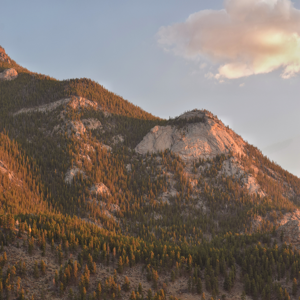

┌────────────────┬───────────┬────────────┐
│ decoded_token  │ frequency │ percentage │
│    varchar     │   int64   │   double   │
├────────────────┼───────────┼────────────┤
│ " the"         │       103 │       40.2 │
│ "0"            │        48 │       18.8 │
│ "\ufffd"       │        22 │        8.6 │
│ " Yosemite"    │        17 │        6.6 │
│ " mountainous" │        15 │        5.9 │
│ " "            │        11 │        4.3 │
│ " Sunset"      │         5 │        2.0 │
│ " mountain"    │         5 │        2.0 │
│ " wooded"      │         4 │        1.6 │
│ " boulder"     │         4 │        1.6 │
│ " Forest"      │         4 │        1.6 │
│ " forested"    │         3 │        1.2 │
│ " sunrise"     │         3 │        1.2 │
│ " lush"        │         2 │        0.8 │
│ " Yellowstone" │         2 │        0.8 │
│ " hilly"       │         1 │        0.4 │
│ "5"            │         1 │        0.4 │
│ " mountains"   │         1 │        0.4 │
│ " timelapse"   │         1 │  

In [7]:
display(Image.open("images/sunrise_mountain.jpg").resize((300, 300)))
dissect_image("images/sunrise_mountain.jpg", model, processor)

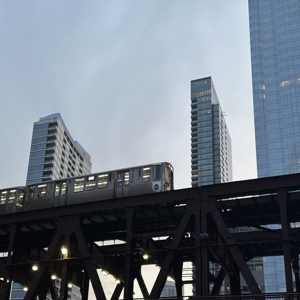

┌────────────────┬───────────┬────────────┐
│ decoded_token  │ frequency │ percentage │
│    varchar     │   int64   │   double   │
├────────────────┼───────────┼────────────┤
│ " the"         │        96 │       37.5 │
│ "0"            │        28 │       10.9 │
│ "the"          │        27 │       10.5 │
│ " "            │        17 │        6.6 │
│ " railroad"    │        11 │        4.3 │
│ " skyscrapers" │         9 │        3.5 │
│ " subway"      │         7 │        2.7 │
│ " train"       │         6 │        2.3 │
│ "\ufffd"       │         6 │        2.3 │
│ " Atlanta"     │         5 │        2.0 │
│ " Seattle"     │         5 │        2.0 │
│ " snowy"       │         4 │        1.6 │
│ " steel"       │         3 │        1.2 │
│ " a"           │         3 │        1.2 │
│ "'"            │         3 │        1.2 │
│ " bridge"      │         2 │        0.8 │
│ " skyline"     │         2 │        0.8 │
│ " Chicago"     │         2 │        0.8 │
│ "tower"        │         2 │  

In [8]:
display(Image.open("images/chicago_l.jpg").resize((300, 300)))
dissect_image("images/chicago_l.jpg", model, processor)

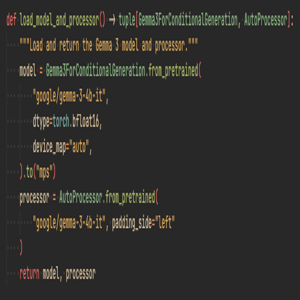

┌─────────────────────────────────────────┬───────────┬────────────┐
│              decoded_token              │ frequency │ percentage │
│                 varchar                 │   int64   │   double   │
├─────────────────────────────────────────┼───────────┼────────────┤
│ " the"                                  │        28 │       10.9 │
│ "'"                                     │        25 │        9.8 │
│ "the"                                   │        21 │        8.2 │
│ "\u2019"                                │        15 │        5.9 │
│ "3"                                     │        10 │        3.9 │
│ "0"                                     │         7 │        2.7 │
│ " Processor"                            │         7 │        2.7 │
│ " "                                     │         7 │        2.7 │
│ "\u2018"                                │         5 │        2.0 │
│ "\u05f3"                                │         4 │        1.6 │
│ "\ufffd"                        

In [9]:
display(Image.open("images/code_snippet.png").resize((300, 300)))
dissect_image("images/code_snippet.png", model, processor)

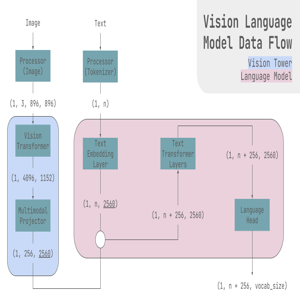

┌────────────────┬───────────┬────────────┐
│ decoded_token  │ frequency │ percentage │
│    varchar     │   int64   │   double   │
├────────────────┼───────────┼────────────┤
│ " the"         │        47 │       18.4 │
│ "0"            │        20 │        7.8 │
│ "\u2019"       │        16 │        6.3 │
│ "5"            │        15 │        5.9 │
│ "the"          │        14 │        5.5 │
│ "1"            │        12 │        4.7 │
│ "\ufffd"       │        10 │        3.9 │
│ " a"           │         7 │        2.7 │
│ " n"           │         7 │        2.7 │
│ "'"            │         7 │        2.7 │
│ "\u2018"       │         7 │        2.7 │
│ "6"            │         6 │        2.3 │
│ "OR"           │         6 │        2.3 │
│ " *"           │         5 │        2.0 │
│ " "            │         4 │        1.6 │
│ " Vision"      │         4 │        1.6 │
│ " LANGUAGE"    │         3 │        1.2 │
│ "odel"         │         3 │        1.2 │
│ " \u3001,"     │         3 │  

In [10]:
display(Image.open("images/vision_language_model_data_flow.png").resize((300, 300)))
dissect_image("images/vision_language_model_data_flow.png", model, processor)

## The Implications: Why This Matters

- They are just language models that learned to speak image: visual information gets translated into the language model's represenation space
- Images getting compressed into 256 tokens is a hard constraint
- But this constraint also enables something remarkable: **language has become the universal interface for AI reasoning**. By forcing all modalities (vision, audio, robotics) through linguistic representations, we've created systems that can reason across domains using the same underlying language model.
- What visual intelligence are we losing by forcing everything through words?